# 전복 나이 예측 경진대회

## 데이터 불러오기

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [249]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/전복-나이-예측/Data/train.csv')
test_ = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/전복-나이-예측/Data/test.csv')

In [34]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [35]:
def drop_id(df: pd.DataFrame) -> None:
    try:
        df.drop('id', axis=1, inplace=True)
    except:
        pass

In [36]:
## 공백을 _(언더바)로 바꾼다
def replace_column_blank2underbar(df: pd.DataFrame) -> None:
    df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_') for column in df.columns])), inplace=True) 

In [37]:
def split_train_target(df: pd.DataFrame, target: str, inplace=True) -> tuple:
    Target = df[target]
    train = df.drop(target, axis=1)
    if inplace:
        del df
    
    return train, Target

In [250]:
tmp = df.copy()
test = test_.copy()

In [251]:
drop_id(tmp)
drop_id(test)

In [252]:
replace_column_blank2underbar(tmp)
replace_column_blank2underbar(test)

In [253]:
tmp['Gender'] = tmp['Gender'].map({'I':0, 'F':1, 'M':2})
test['Gender'] = test['Gender'].map({'I':0, 'F':1, 'M':2})

In [254]:
data_train_T=tmp['Target']
target=[]
for i in range(len(data_train_T)):
    if data_train_T.iloc[i] < 10:
        target.append(1)
    elif data_train_T.iloc[i] < 15:
        target.append(2)
    else:
        target.append(3)
        
tmp['Range'] = target

In [255]:
data_train_3 = tmp[tmp['Range']==3]

In [256]:
tmp = tmp.append(data_train_3)

In [257]:
tmp.drop('Range', axis=1, inplace=True)

In [258]:
tmp, target = split_train_target(tmp, 'Target')

In [259]:
skfold = StratifiedKFold(n_splits=5,  shuffle=True, random_state=22)

In [260]:
xgb = XGBRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 1000, max_depth = 6)

In [261]:
lgbm = LGBMRegressor(random_state=22, learning_rate=0.05, n_estimators=1000, max_depth=5)

In [262]:
cb = CatBoostRegressor(random_state = 222, learning_rate = 0.03, n_estimators = 1000, depth = 6, loss_function = 'MAE', verbose = 0)

In [263]:
log_target = np.log(target)

In [274]:
def fold_training(df, log_target, stratify, test, model, skfold):
    """target은 로그 변환 되어야 함"""
    model_valid = []
    model_predict = np.zeros(test.shape[0])

    
    for fold, (train_idx, valid_idx) in enumerate(skfold.split(df, df[stratify])):
        print(f'{fold + 1} Fold Training......')
        x_train, y_train = df.iloc[train_idx], log_target.iloc[train_idx]
        x_valid, y_valid = df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])

        model.fit(x_train, y_train, 
                  eval_set=(x_valid, y_valid),
                  eval_metric='l1', verbose=False, early_stopping_rounds=100)
   
        y_predict = np.exp(model.predict(x_valid)) ## valid셋 예측
        test_predict = np.exp(model.predict(test)) ## test셋 예측
        nmae = NMAE(y_predict, y_valid)
        model_valid.append(nmae) ## valid 예측값
        model_predict += test_predict / skfold.n_splits ## test 예측값
        print(f'nmae : {nmae:.4f}', end='\n\n')
        
    model_dict = {cb.__class__.__name__:model,
                  'valid':model_valid,
                  'predict':model_predict,
                 }
    
    return  model_dict

In [272]:
lgbm_dict = fold_training(tmp, log_target, 'Gender', test, lgbm, skfold)

1 Fold Training......
nmae : 0.1682

2 Fold Training......
nmae : 0.2534

3 Fold Training......
nmae : 0.2572

4 Fold Training......
nmae : 0.2685

5 Fold Training......
nmae : 0.1762



In [273]:
np.mean(lgbm_dict['valid'])

0.224702624305836

<AxesSubplot:>

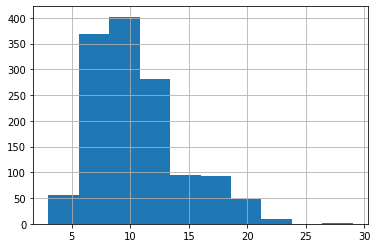

In [270]:
target.hist()

(array([105., 210., 371., 779., 855., 356., 149.,  70.,  19.,  10.]),
 array([ 7.36506127,  7.99474729,  8.62443331,  9.25411933,  9.88380534,
        10.51349136, 11.14317738, 11.7728634 , 12.40254942, 13.03223543,
        13.66192145]),
 <BarContainer object of 10 artists>)

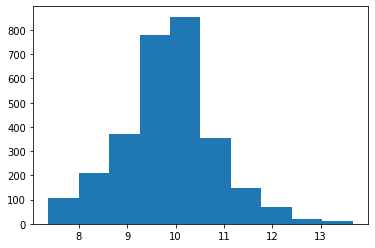

In [267]:
plt.hist(lgbm_dict['predict'])